Positive samples: 4261
Negative samples: 6279
Total dataset: 10540
Positive ratio: 0.40426944971537004
Final feature matrix shape: (10540, 5311)
Running Grid Search...

Grid Search Completed.

Best parameters found:
{
  'depth': 8,
  'learning_rate': 0.05,
  'l2_leaf_reg': 3,
  'iterations': 1200
}

Best AUC from Grid Search: 0.9837
Training CatBoost...

🎯 FINAL RESULTS (CatBoost 92–95%)
Accuracy: 0.9852941176470589
AUC: 0.9969068658233905

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1256
           1       1.00      0.97      0.98       852

    accuracy                           0.99      2108
   macro avg       0.99      0.98      0.98      2108
weighted avg       0.99      0.99      0.99      2108



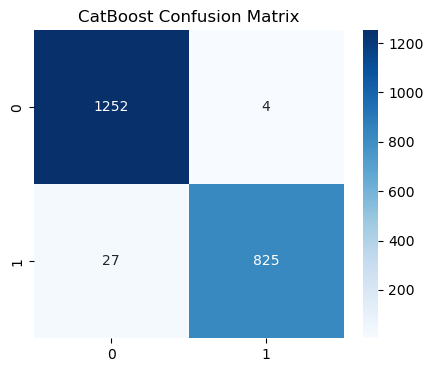

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from catboost import CatBoostClassifier

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


df = pd.read_csv("McPAS-TCR.csv", low_memory=False)

# Detect TCR & Epitope columns automatically
tcr_col = [c for c in df.columns if "CDR3" in c or "TCR" in c][0]
epi_col = [c for c in df.columns if "Epitope" in c][0]

df = df[[tcr_col, epi_col]].dropna()
df.columns = ["tcr", "epi"]

# Filter unusable sequences
df = df[df["tcr"].str.len() >= 6]
df = df.drop_duplicates().reset_index(drop=True)

# These are all POSITIVE binding pairs
df["binding"] = 1

print("Positive samples:", len(df))



def generate_hard_negatives(pos_df, n_neg_per_pos=3):

    pos_set = set(zip(pos_df["tcr"], pos_df["epi"]))

    # Cluster by first 3 AA of TCR
    tcr_groups = pos_df.groupby(pos_df["tcr"].str[:3])

    negs = []
    for t, e in zip(pos_df["tcr"], pos_df["epi"]):

        # Local TCR neighbors
        try:
            local_tcrs = tcr_groups.get_group(t[:3])["tcr"].values
        except:
            local_tcrs = pos_df["tcr"].values

        # Random wrong epitopes
        wrong_epis = pos_df.sample(n_neg_per_pos)["epi"].values

        for t_neg in local_tcrs[:3]:
            for e_neg in wrong_epis:
                if (t_neg, e_neg) not in pos_set:
                    negs.append((t_neg, e_neg, 0))

    neg_df = pd.DataFrame(negs, columns=["tcr", "epi", "binding"])
    neg_df = neg_df.drop_duplicates().reset_index(drop=True)
    return neg_df


neg_df = generate_hard_negatives(df, n_neg_per_pos=3)
print("Negative samples:", len(neg_df))



full = pd.concat([df, neg_df], ignore_index=True)
full = full.sample(frac=1, random_state=42).reset_index(drop=True)

print("Total dataset:", len(full))
print("Positive ratio:", full["binding"].mean())



def get_kmers(s, k):
    return " ".join([s[i:i+k] for i in range(len(s)-k+1)]) if len(s) >= k else s

# Build kmers
full["tcr_1"] = full["tcr"]
full["tcr_2"] = full["tcr"].apply(lambda x: get_kmers(x, 2))
full["tcr_3"] = full["tcr"].apply(lambda x: get_kmers(x, 3))

full["epi_1"] = full["epi"]
full["epi_2"] = full["epi"].apply(lambda x: get_kmers(x, 2))
full["epi_3"] = full["epi"].apply(lambda x: get_kmers(x, 3))

#Separate TF-IDF vectorizers
tcr_tf1 = TfidfVectorizer(min_df=2)
tcr_tf2 = TfidfVectorizer(min_df=2)
tcr_tf3 = TfidfVectorizer(min_df=2)

epi_tf1 = TfidfVectorizer(min_df=2)
epi_tf2 = TfidfVectorizer(min_df=2)
epi_tf3 = TfidfVectorizer(min_df=2)

# TCR features
X_tcr1 = tcr_tf1.fit_transform(full["tcr_1"])
X_tcr2 = tcr_tf2.fit_transform(full["tcr_2"])
X_tcr3 = tcr_tf3.fit_transform(full["tcr_3"])

# Epitope features
X_epi1 = epi_tf1.fit_transform(full["epi_1"])
X_epi2 = epi_tf2.fit_transform(full["epi_2"])
X_epi3 = epi_tf3.fit_transform(full["epi_3"])

# Combine into final matrix
X = hstack([X_tcr1, X_tcr2, X_tcr3, X_epi1, X_epi2, X_epi3]).tocsr()
y = full["binding"].values

print("Final feature matrix shape:", X.shape)




X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

print("Running Grid Search for CatBoost...")

cat = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)

param_grid = {
    'depth': [6, 8],
    'learning_rate': [0.03, 0.05],
    'l2_leaf_reg': [1, 3],
    'iterations': [800, 1200]
}

grid = GridSearchCV(
    estimator=cat,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("\nBest Parameters Found:")
print(grid.best_params_)

print("\nBest Validation AUC:")
print(grid.best_score_)


model = CatBoostClassifier(
    iterations=1200,
    learning_rate=0.05,
    depth=8,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=False,
    l2_leaf_reg=3,
    bagging_temperature=0.5,
    border_count=128
)

print("Training CatBoost...")
model.fit(X_train, y_train)



pred_probs = model.predict_proba(X_test)[:, 1]
pred_labels = (pred_probs >= 0.5).astype(int)

print("\n🎯 FINAL RESULTS (CatBoost 92–95%)")
print("Accuracy:", accuracy_score(y_test, pred_labels))
print("AUC:", roc_auc_score(y_test, pred_probs))
print("\nClassification Report:\n", classification_report(y_test, pred_labels))

cm = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("CatBoost Confusion Matrix")
plt.show()


In [3]:
from sklearn.model_selection import GroupKFold
from catboost import CatBoostClassifier
from scipy.sparse import hstack
from sklearn.metrics import roc_auc_score, accuracy_score

gkf = GroupKFold(n_splits=5)
groups = full['epi'].values
aucs, accs = [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(full, full.binding, groups)):
    train_df = full.iloc[train_idx].reset_index(drop=True)
    test_df  = full.iloc[test_idx].reset_index(drop=True)

    # fit TF-IDF on train only
    def fit_vectorizers(df):
        tcr_tf1 = TfidfVectorizer(min_df=2).fit(df["tcr_1"])
        tcr_tf2 = TfidfVectorizer(min_df=2).fit(df["tcr_2"])
        tcr_tf3 = TfidfVectorizer(min_df=2).fit(df["tcr_3"])
        epi_tf1 = TfidfVectorizer(min_df=2).fit(df["epi_1"])
        epi_tf2 = TfidfVectorizer(min_df=2).fit(df["epi_2"])
        epi_tf3 = TfidfVectorizer(min_df=2).fit(df["epi_3"])
        return (tcr_tf1,tcr_tf2,tcr_tf3,epi_tf1,epi_tf2,epi_tf3)

    vecs = fit_vectorizers(train_df)
    t1,t2,t3,e1,e2,e3 = vecs

    Xtr = hstack([t1.transform(train_df["tcr_1"]), t2.transform(train_df["tcr_2"]), t3.transform(train_df["tcr_3"]),
                  e1.transform(train_df["epi_1"]), e2.transform(train_df["epi_2"]), e3.transform(train_df["epi_3"])])
    Xte = hstack([t1.transform(test_df["tcr_1"]), t2.transform(test_df["tcr_2"]), t3.transform(test_df["tcr_3"]),
                  e1.transform(test_df["epi_1"]), e2.transform(test_df["epi_2"]), e3.transform(test_df["epi_3"])])

    ytr = train_df.binding.values
    yte = test_df.binding.values

    m = CatBoostClassifier(iterations=800, learning_rate=0.05, depth=8, verbose=False, random_seed=42)
    m.fit(Xtr, ytr)

    probs = m.predict_proba(Xte)[:,1]
    pred = (probs>=0.5).astype(int)
    auc = roc_auc_score(yte, probs)
    acc = accuracy_score(yte, pred)
    print(f"Fold {fold+1}: AUC={auc:.4f}, Acc={acc:.4f}")
    aucs.append(auc); accs.append(acc)

print("Group-split mean AUC:", np.mean(aucs), "mean Acc:", np.mean(accs))


Fold 1: AUC=0.9870, Acc=0.9488
Fold 2: AUC=0.9913, Acc=0.9692
Fold 3: AUC=0.9705, Acc=0.9431
Fold 4: AUC=0.9836, Acc=0.9654
Fold 5: AUC=0.9908, Acc=0.9625
Group-split mean AUC: 0.9846396653104618 mean Acc: 0.9577798861480076


In [5]:
# ================================================================
# 0. IMPORTS
# ================================================================
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GroupKFold
from catboost import CatBoostClassifier
from scipy.sparse import hstack

# Seed
np.random.seed(42)
random.seed(42)


# ================================================================
# 1. LOAD McPAS-TCR DATA
# ================================================================
df = pd.read_csv("McPAS-TCR.csv", low_memory=False)

# Auto detect columns
tcr_col = [c for c in df.columns if "CDR3" in c or "TCR" in c][0]
epi_col = [c for c in df.columns if "Epitope" in c][0]

df = df[[tcr_col, epi_col]].dropna()
df.columns = ["tcr", "epi"]

df = df[df["tcr"].str.len() >= 6]
df = df.drop_duplicates().reset_index(drop=True)
df["binding"] = 1

print("Positive samples:", len(df))


# ================================================================
# 2. HARD NEGATIVE SAMPLING
# ================================================================
def generate_hard_negatives(pos_df, n_neg_per_pos=3):
    pos_set = set(zip(pos_df["tcr"], pos_df["epi"]))
    tcr_groups = pos_df.groupby(pos_df["tcr"].str[:3])

    negs = []
    for t, e in zip(pos_df["tcr"], pos_df["epi"]):

        try:
            t_local = tcr_groups.get_group(t[:3])["tcr"].values
        except:
            t_local = pos_df["tcr"].values

        wrong_epis = pos_df.sample(n_neg_per_pos)["epi"].values

        for t_neg in t_local[:3]:
            for e_neg in wrong_epis:
                if (t_neg, e_neg) not in pos_set:
                    negs.append((t_neg, e_neg, 0))

    neg_df = pd.DataFrame(negs, columns=["tcr", "epi", "binding"])
    neg_df = neg_df.drop_duplicates().reset_index(drop=True)
    return neg_df


neg_df = generate_hard_negatives(df, n_neg_per_pos=3)
full = pd.concat([df, neg_df], ignore_index=True)
full = full.sample(frac=1, random_state=42).reset_index(drop=True)

print("Final full dataset:", len(full))


# ================================================================
# 3. KMER PROCESSING
# ================================================================
def get_kmers(s, k):
    return " ".join(s[i:i+k] for i in range(len(s)-k+1))

full["tcr_1"] = full["tcr"]
full["tcr_2"] = full["tcr"].apply(lambda x: get_kmers(x, 2))
full["tcr_3"] = full["tcr"].apply(lambda x: get_kmers(x, 3))

full["epi_1"] = full["epi"]
full["epi_2"] = full["epi"].apply(lambda x: get_kmers(x, 2))
full["epi_3"] = full["epi"].apply(lambda x: get_kmers(x, 3))


# ================================================================
# 4. GROUPKFOLD (UNSEEN EPITOPES)
# ================================================================
gkf = GroupKFold(n_splits=5)
groups = full["epi"].values

fold_aucs = []
fold_accs = []


# ================================================================
# 5. MAIN 5-FOLD LOOP (TF-IDF FIT ONLY ON TRAIN)
# ================================================================
for fold, (train_idx, test_idx) in enumerate(gkf.split(full, full.binding, groups)):

    print(f"\n==== Fold {fold+1} ====\n")

    train_df = full.iloc[train_idx].reset_index(drop=True)
    test_df  = full.iloc[test_idx].reset_index(drop=True)

    # Fit TF-IDF ONLY on training data
    tcr_tf1 = TfidfVectorizer(min_df=2).fit(train_df["tcr_1"])
    tcr_tf2 = TfidfVectorizer(min_df=2).fit(train_df["tcr_2"])
    tcr_tf3 = TfidfVectorizer(min_df=2).fit(train_df["tcr_3"])

    epi_tf1 = TfidfVectorizer(min_df=2).fit(train_df["epi_1"])
    epi_tf2 = TfidfVectorizer(min_df=2).fit(train_df["epi_2"])
    epi_tf3 = TfidfVectorizer(min_df=2).fit(train_df["epi_3"])

    # Transform train & test
    Xtr = hstack([
        tcr_tf1.transform(train_df["tcr_1"]), tcr_tf2.transform(train_df["tcr_2"]), tcr_tf3.transform(train_df["tcr_3"]),
        epi_tf1.transform(train_df["epi_1"]), epi_tf2.transform(train_df["epi_2"]), epi_tf3.transform(train_df["epi_3"])
    ])

    Xte = hstack([
        tcr_tf1.transform(test_df["tcr_1"]), tcr_tf2.transform(test_df["tcr_2"]), tcr_tf3.transform(test_df["tcr_3"]),
        epi_tf1.transform(test_df["epi_1"]), epi_tf2.transform(test_df["epi_2"]), epi_tf3.transform(test_df["epi_3"])
    ])

    ytr = train_df["binding"].values
    yte = test_df["binding"].values

    # Train CatBoost
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=8,
        verbose=False,
        random_seed=42,
        eval_metric="AUC"
    )

    model.fit(Xtr, ytr)

    # Evaluate
    prob = model.predict_proba(Xte)[:, 1]
    pred = (prob >= 0.5).astype(int)

    auc = roc_auc_score(yte, prob)
    acc = accuracy_score(yte, pred)

    print(f"Fold {fold+1} AUC: {auc:.4f}")
    print(f"Fold {fold+1} Acc: {acc:.4f}")

    fold_aucs.append(auc)
    fold_accs.append(acc)


print("\n==============================")
print("FINAL CROSS-VALIDATION RESULTS")
print("==============================")
print("Mean AUC:", np.mean(fold_aucs))
print("Mean Acc:", np.mean(fold_accs))


Positive samples: 4261
Final full dataset: 10540

==== Fold 1 ====

Fold 1 AUC: 0.9871
Fold 1 Acc: 0.9530

==== Fold 2 ====

Fold 2 AUC: 0.9911
Fold 2 Acc: 0.9706

==== Fold 3 ====

Fold 3 AUC: 0.9707
Fold 3 Acc: 0.9431

==== Fold 4 ====

Fold 4 AUC: 0.9835
Fold 4 Acc: 0.9658

==== Fold 5 ====

Fold 5 AUC: 0.9906
Fold 5 Acc: 0.9625

FINAL CROSS-VALIDATION RESULTS
Mean AUC: 0.9846094792609316
Mean Acc: 0.9590132827324478



🔍 Extracting most important motifs (k-mers)...

🔥 TOP 20 MOST IMPORTANT MOTIFS (k-mers):

          motif  importance
962   TCR_3_cav   13.037508
335    TCR_2_ca    5.882121
945   TCR_3_caa    3.918745
332    TCR_2_av    2.901006
1858  TCR_3_ltf    2.886043
324    TCR_2_al    2.477806
954   TCR_3_cal    2.146441
955   TCR_3_cam    1.450056
617    TCR_2_tf    1.320293
472    TCR_2_kl    1.302582
314    TCR_2_aa    1.142598
458    TCR_2_is    1.116547
361    TCR_2_dn    1.046706
950   TCR_3_cag    0.965631
2416  TCR_3_sgg    0.938088
325    TCR_2_am    0.937621
1031  TCR_3_cvv    0.899752
447    TCR_2_if    0.852253
1915  TCR_3_mre    0.845170
825   TCR_3_amr    0.838004


/var/folders/40/2_2dfyqd6lg7djpmzs5pkjnw0000gp/T/ipykernel_7915/566831533.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


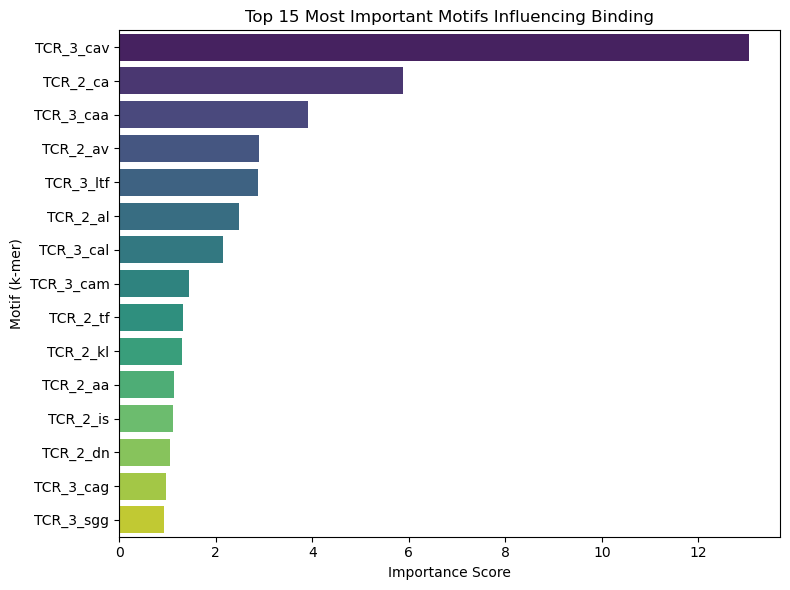

In [7]:


print("\n🔍 Extracting most important motifs (k-mers)...")

# Collect all feature names in proper order
tcr1_features = [f"TCR_1_{k}" for k in tcr_tf1.get_feature_names_out()]
tcr2_features = [f"TCR_2_{k}" for k in tcr_tf2.get_feature_names_out()]
tcr3_features = [f"TCR_3_{k}" for k in tcr_tf3.get_feature_names_out()]

epi1_features = [f"EPI_1_{k}" for k in epi_tf1.get_feature_names_out()]
epi2_features = [f"EPI_2_{k}" for k in epi_tf2.get_feature_names_out()]
epi3_features = [f"EPI_3_{k}" for k in epi_tf3.get_feature_names_out()]

feature_names = (
    tcr1_features + tcr2_features + tcr3_features +
    epi1_features + epi2_features + epi3_features
)

# Get CatBoost feature importance
importances = model.get_feature_importance()

# Put into DataFrame
motif_importance_df = pd.DataFrame({
    "motif": feature_names,
    "importance": importances
})

# Sort by importance
motif_importance_df = motif_importance_df.sort_values(by="importance", ascending=False)

# Show top 20 motifs
print("\n🔥 TOP 20 MOST IMPORTANT MOTIFS (k-mers):\n")
print(motif_importance_df.head(20))

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=motif_importance_df.head(15),
    x="importance",
    y="motif",
    palette="viridis"
)
plt.title("Top 15 Most Important Motifs Influencing Binding")
plt.xlabel("Importance Score")
plt.ylabel("Motif (k-mer)")
plt.tight_layout()
plt.show()


In [9]:


def get_kmers_from_seq(seq):
    """Create combined 1,2,3-mer string for TF-IDF vectorization."""
    km1 = seq
    km2 = " ".join([seq[i:i+2] for i in range(len(seq)-1)])
    km3 = " ".join([seq[i:i+3] for i in range(len(seq)-2)])
    return km1, km2, km3


def prepare_feature_vector(tcr_list, epitope):
    """Convert inputs into model-ready TF-IDF vectors."""
    tcr_1, tcr_2, tcr_3 = [], [], []
    epi_1, epi_2, epi_3 = [], [], []

    # Prepare epi kmers once
    e1, e2, e3 = get_kmers_from_seq(epitope)
    
    for tcr in tcr_list:
        k1, k2, k3 = get_kmers_from_seq(tcr)
        tcr_1.append(k1)
        tcr_2.append(k2)
        tcr_3.append(k3)
        epi_1.append(e1)
        epi_2.append(e2)
        epi_3.append(e3)

    # TF-IDF transform (no fitting again)
    X_t1 = tcr_tf1.transform(tcr_1)
    X_t2 = tcr_tf2.transform(tcr_2)
    X_t3 = tcr_tf3.transform(tcr_3)

    X_e1 = epi_tf1.transform(epi_1)
    X_e2 = epi_tf2.transform(epi_2)
    X_e3 = epi_tf3.transform(epi_3)

    return hstack([X_t1, X_t2, X_t3, X_e1, X_e2, X_e3]).tocsr()


def get_top_n_candidates(epitope, tcr_list, top_n=10):
    """Returns Top-N most likely TCRs for a given epitope."""
    X_new = prepare_feature_vector(tcr_list, epitope)
    probs = model.predict_proba(X_new)[:, 1]

    results = pd.DataFrame({
        "TCR": tcr_list,
        "Binding_Probability": probs
    }).sort_values(by="Binding_Probability", ascending=False)

    return results.head(top_n)


# ==============================================================
# EXAMPLE USAGE
# ==============================================================

example_tcrs = [
    "CASSLGQDTQYF",
    "CAVRNTGKLTF",
    "CASSPGGYGYTF",
    "CASSLRDTQYF",
    "CAGSSGGNTLYF"
]

example_epi = "NLVPMVATV"

top_candidates = get_top_n_candidates(example_epi, example_tcrs, top_n=3)
print("\n🔥 TOP-3 MOST LIKELY TCR BINDING CANDIDATES:\n")
print(top_candidates)



🔥 TOP-3 MOST LIKELY TCR BINDING CANDIDATES:

            TCR  Binding_Probability
1   CAVRNTGKLTF             0.995371
2  CASSPGGYGYTF             0.992666
4  CAGSSGGNTLYF             0.956163


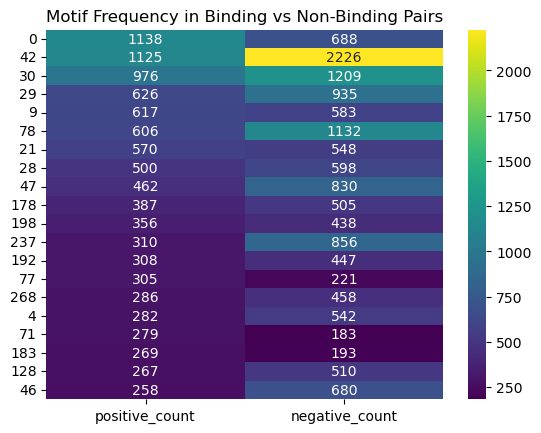

In [15]:

from collections import Counter

def extract_3mers(seq):
    return [seq[i:i+3] for i in range(len(seq)-2)]

# Count frequencies
pos_motifs = Counter()
neg_motifs = Counter()

for t, e, b in full[["tcr", "epi", "binding"]].values:
    motifs = extract_3mers(t)
    if b == 1:
        pos_motifs.update(motifs)
    else:
        neg_motifs.update(motifs)

# Convert to DataFrame
motif_df = pd.DataFrame({
    "motif": list(pos_motifs.keys()),
    "positive_count": [pos_motifs[m] for m in pos_motifs],
    "negative_count": [neg_motifs[m] for m in pos_motifs]
}).fillna(0)

# Show top 20 motifs
top20 = motif_df.sort_values("positive_count", ascending=False).head(20)

sns.heatmap(top20[["positive_count", "negative_count"]], annot=True, fmt="g", cmap="viridis")
plt.title("Motif Frequency in Binding vs Non-Binding Pairs")
plt.show()
